In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [2]:
import networkx as nx

In [3]:
import seaborn as sns

In [4]:
ls = pd.read_csv("ladestationen.csv")
st = pd.read_csv("stadtteile.csv")

In [5]:
st["Bedarf"].sum()

311.49

<AxesSubplot:xlabel='x', ylabel='y'>

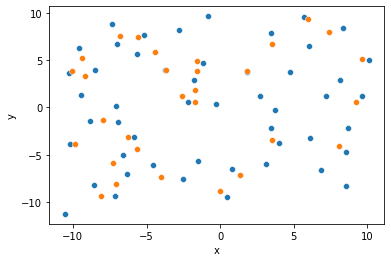

In [6]:
sns.scatterplot(x=ls["x"], y=ls["y"])
sns.scatterplot(x=st["x"], y=st["y"])

In [7]:
def dist(i,j):
    return np.sqrt((ls.iloc[i].x-ls.iloc[j].x)**2 + (st.iloc[i].y-ls.iloc[j].y)**2)

In [8]:
distances = pd.DataFrame(np.fromfunction(np.vectorize(dist), (30,50), dtype=int))

In [9]:
distances.index = st["Name"]
distances.columns = ls["Name"]

In [10]:
ls["Angebot"] = 40

In [11]:
G = nx.DiGraph()

for i in range(30):
    sink = st.iloc[i]
    G.add_node(sink.Name, demand=round(sink.Bedarf))
    
for j in range(8):
    source = ls.iloc[j]
    G.add_node(source.Name, demand=-round(source.Angebot))
    for i in range(30):
        sink = st.iloc[i]
        G.add_edge(source.Name, sink.Name, weight=round(100*dist(i,j)))

surplus = sum([x[1]["demand"] for x in G.nodes(data=True)])
print(surplus)
G.add_node("NORMALIZER", demand=-surplus)
for node in G.nodes:
    if surplus <= 0:
        G.add_edge(node, "NORMALIZER", weight=10000)
    else:
        G.add_edge("NORMALIZER", node, weight=10000)

-8.0


In [12]:
flowCost, flowDict = nx.network_simplex(G)

In [13]:
def filterempty(x):
    return {k:v for k, v in filter(lambda x: x[1]>0,x.items())}

In [14]:
activeFlow = {k:filterempty(v) for k,v in flowDict.items() if len(filterempty(v))>0}